# Animal classification AI
# Linear baseline model

## TOC
- Student info
- Important note
- Important note
- Special credits
- Required imports and basic setup
- Step 1: Loading the data
   - 1.a: Saving the labels
   - 1.b: Saving dictionary of file paths
- Step 2: Data analysis
   - 2.a: showing some images
- Step 3: Choosing the descriptor
   - 3.a: Loading in the pickle data
   - 3.b: Encoding the images
   - 3.c: Validate loaded data
- Step 4: Making validation set(s) and test set(s)
- Step 5: Training the model
- Step 6: Generating CSV for submission
- Step 7: finetuning the model
   - 7.a: Fine-tuning the input
      - 7.a.I: Automated functions
      - 7.a.II: Trying small cluster amounts for all supplied descriptors
      - 7.a.III: Trying large cluster amounts for all supplied descriptors
   - 7.b: Fine-tuning the validation set
      - 7.b.I: Automated functions
      - 7.b.II: Finding optimal for optimal descriptor
   - 7.c: Fine-tuning the model parameters
      - 7.c.I: Automated functions
      - 7.c.II: class_weight parameter
      - 7.c.III: fit_intercept parameter
      - 7.c.IV: max_iter parameter
      - 7.c.V: C parameter
   

## Student info
- **Name**: Bontinck Lennert
- **StudentID**: 568702
- **Affiliation**: VUB - Master Computer Science: AI

## Important note
In some codeblocks, the code might refer to variables from previous sections, in order to get accurate results code must be run top to bottom without skipping.

## Special credits
Some of the code used in this notebook is adopted or copied from the notebooks supplied in the Kaggle compition. A special thanks is given to Andries Rosseau for supplying us with this helpfull code.

## Required imports basic setup
All required imports for this file are taken care of once using the following code block. Installing the required libraries is discussed in the README of this GitHub repository. Some basic setup for the used libraries is also taken care of here

In [17]:
#set current optima
optima_class_weight = None
optima_C = 3
optima_max_iter = 250
optima_fit_intercept = True
optima_test_fraction = 0.15
optima_test_fraction_balanced = True
optima_descriptor = "sift"
optima_clusters = 100

In [18]:
# standard packages used to handle files
import sys
import os 
import glob
import time

# commonly used library for data manipulation
import pandas as pd

# numerical
import numpy as np

# handle images - opencv
import cv2

# model
from sklearn.linear_model import LogisticRegression

# machine learning library
import sklearn
import sklearn.preprocessing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline, Pipeline

# scoring
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from scipy import stats as sstats

# used to serialize python objects to disk and load them back to memory
import pickle

# plotting
import matplotlib.pyplot as plt

# helper functions
import helpers
import more_helpers

# specific helper functions for feature extraction
import features

# tell matplotlib that we plot in a notebook and make images high(er) resolution
%matplotlib inline
%config InlineBackend.figure_formats = {'png', 'svg'}

# used for counting files
import fnmatch

In [3]:
# datasets  location
dataset_path = '../images/'
# output location:
output_path = './'

In [4]:
# other path settings
dataset_path_train = os.path.join(dataset_path, 'train')
dataset_path_test = os.path.join(dataset_path, 'test')

features_path = os.path.join(output_path, 'features')
features_path_train = os.path.join(features_path, 'train')
features_path_test = os.path.join(features_path, 'test')

prediction_path = os.path.join(output_path, 'predictions')

# filepatterns to write out features
filepattern_descriptor_train = os.path.join(features_path_train, 'train_features_{}.pkl')
filepattern_descriptor_test = os.path.join(features_path_test, 'test_features_{}.pkl')

# create paths in case they don't exist:
helpers.createPath(features_path)
helpers.createPath(features_path_train)
helpers.createPath(features_path_test)
helpers.createPath(prediction_path)

## Step 1: Loading the data
Before we can start exploring our data and making models we have to setup everything that is needed to access the data.

The data is provided in the Kaggle compition and saved under a folder "test" and "train" inside the folder "images" which is saved in this files parent directory as set up in the previous basic setup step.

### 1.a: Saving the labels
The training data provided is saved inside a folder which name corresponds to the label of the data inside that folder. Thus getting the labels of the data is nothing more then getting all folder names inside the "train" folder.

In [5]:
train_images_folder_paths = glob.glob(os.path.join(dataset_path_train,'*'))
label_strings = np.sort(np.array([os.path.basename(path) for path in train_images_folder_paths]))
amount_of_labels = label_strings.shape[0]

print("Amount of classes (labels): ", amount_of_labels)
print("\nLabels: ", label_strings)

Amount of classes (labels):  12

Labels:  ['chicken' 'elephant' 'fox' 'german_shepherd' 'golden_retriever' 'horse'
 'jaguar' 'lion' 'owl' 'parrot' 'swan' 'tiger']


### 1.b: Saving dictionary of file paths
Since loading all images of the train set into memory at once is hardly feasible, we simply collect all their filepaths and load them on demand. Therefore, we build a dictionary of the filepaths to all our train images, sorted by label. We do the same for our test images.

In [6]:
train_paths = dict((label_string, helpers.getImgPaths(os.path.join(dataset_path_train, label_string))) 
                   for label_string in label_strings)

test_paths = helpers.getImgPaths(dataset_path_test)

## Step 2: Data analysis
Before rigorously testing different models available it's important to take a look at the data that's supplied to us. This will not only validate the data is correctly loaded in the previous step but will also give us some hint as to what our data looks like, what it's distribution is...

This step can be done in a separate Jupyter Notebook "data_analysis" and thus the code is not repeated here, we do however print some of the images here to be sure the setup in the previous step succeeded

### 2.a: showing some images
In this step we'll display the first five images in the train set provided for the Kaggle compitition.

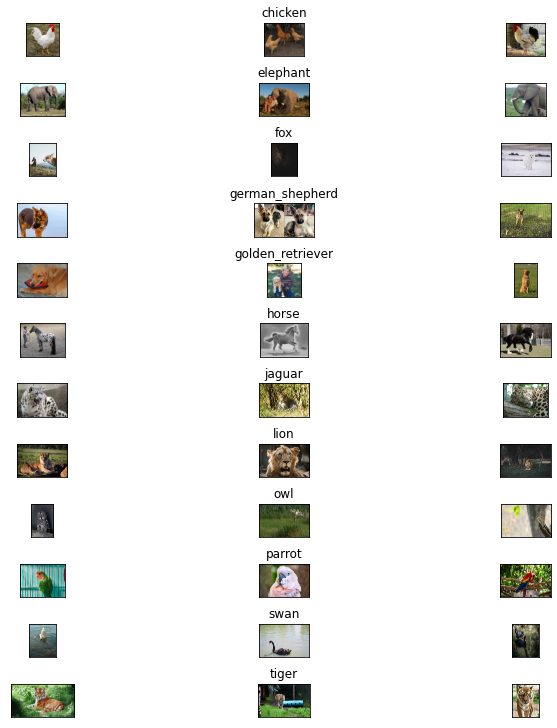

In [7]:
fig, axes = plt.subplots(nrows=amount_of_labels, ncols=3, constrained_layout=True, figsize=(10, 10))

[ax.get_xaxis().set_visible(False) for ax_row in axes for ax in ax_row]
[ax.get_yaxis().set_visible(False) for ax_row in axes for ax in ax_row]

for idx, label_string in enumerate(label_strings):
    images = [cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB) for path in train_paths[label_string][:5]]

    for colidx in range(3):
        axes[idx, colidx].imshow(images[colidx])
        if colidx == 1: # if this is the center column
            axes[idx, colidx].set_title(label_string)

plt.show()    

## Step 3: Choosing the descriptor
From the information gathered in step 2, a preffered descriptor and proposed amount of clusters is loaded.

### 3.a: Loading in the pickle data
The "descriptor_desired" and "amount_of_clusters" parameters could benefit from fine-tuning. See inline comment to check wether or not they have been fine-tuned. More details in section: Fine-tuning the input.

The default "createCodebook" helper function is used to cluster the data. This can be optimised later.

In [8]:
# fine-tuning of these parameters has been done! See report for more details, section: Fine-tuning the input
descriptor_desired = optima_descriptor
amount_of_clusters = optima_clusters

# ----------------- open pickle files ----------------- 
with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)
    
print('Number of encoded train images: {}'.format(len(train_features_from_pkl)))

with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)
        
print('Number of encoded test images: {}'.format(len(test_features_from_pkl)))

# ----------------- get the wanted features ----------------- 
# use default mini k cluster
clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=amount_of_clusters)

Number of encoded train images: 4042
Number of encoded test images: 4035
training took 29.502643585205078 seconds


### 3.b: Encoding the images
It's important to note that the test data has to be encoded using the same logic as well!

In [9]:
# ----------------- encode all train images ----------------- 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)
    
# ----------------- make labels numerical ----------------- 
train_labels_text = train_labels[:]

label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

print(train_labels_text[:10])
print(train_labels[:10])
    
# ----------------- encode all test images ----------------- 
test_data_by_kaggle = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data_by_kaggle.append(bow_feature_vector)

['chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken', 'chicken']
[0 0 0 0 0 0 0 0 0 0]


### 3.c: Validate loaded data
This step prints some output to check wether or not the previous step succeeded.

In [10]:
# ----------------- print some info ----------------- 
print("Amoount of interesting points available: ", len(train_features_from_pkl[0][2]))
print("Amoount of clusters requested: ", len(train_data[0]))

print("\nTrain labels: ", train_labels[:1])
print("Train data: \n", train_data[:1])

print("\nTest data by Kaggle: \n", test_data_by_kaggle[:1])

Amoount of interesting points available:  500
Amoount of clusters requested:  100

Train labels:  [0]
Train data: 
 [array([0.06380632, 0.27117687, 0.09570948, 0.01595158, 0.0797579 ,
       0.04785474, 0.06380632, 0.12761265, 0.0797579 , 0.03190316,
       0.15951581, 0.06380632, 0.03190316, 0.06380632, 0.0797579 ,
       0.04785474, 0.11166106, 0.06380632, 0.09570948, 0.06380632,
       0.11166106, 0.        , 0.09570948, 0.        , 0.01595158,
       0.09570948, 0.06380632, 0.01595158, 0.03190316, 0.01595158,
       0.04785474, 0.14356423, 0.11166106, 0.09570948, 0.15951581,
       0.06380632, 0.25522529, 0.14356423, 0.06380632, 0.04785474,
       0.0797579 , 0.14356423, 0.03190316, 0.12761265, 0.03190316,
       0.09570948, 0.03190316, 0.01595158, 0.17546739, 0.06380632,
       0.03190316, 0.01595158, 0.06380632, 0.06380632, 0.19141897,
       0.04785474, 0.04785474, 0.03190316, 0.20737055, 0.        ,
       0.03190316, 0.14356423, 0.06380632, 0.09570948, 0.03190316,
       0.031

## Step 4: Making validation set(s) and test set(s)
As per requirement of the Kaggle compitition, the score on the test data can not be used for optimilisation.
This is logical since the score would then not represent a score on completely unseen data anymore.
This is why we need to split the training data a second time into a training set and a validation set.

This splitting could benefit from fine-tuning.
See inline comment to check wether or not it has been fine-tuned.
It is chosen to take into account the unbalance of the dataset given.
More information in section: Fine-tuning the validation set

In [11]:
# fine-tuning of these parameters has been done! See report for more details, section: Fine-tuning the validation set
test_fraction = optima_test_fraction
balanced = optima_test_fraction_balanced

if balanced:
    train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, stratify=train_labels)
else:
    train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, random_state=0)


#validating the split
print("Train labels: ", train_labels_split[:2])
print("\nTrain data: \n", train_data_split[:2])

Train labels:  [7 1]

Train data: 
 [array([0.        , 0.06311944, 0.06311944, 0.04733958, 0.01577986,
       0.25247776, 0.12623888, 0.03155972, 0.09467916, 0.1577986 ,
       0.12623888, 0.11045902, 0.0788993 , 0.17357846, 0.09467916,
       0.01577986, 0.01577986, 0.09467916, 0.1577986 , 0.09467916,
       0.03155972, 0.        , 0.        , 0.06311944, 0.03155972,
       0.04733958, 0.12623888, 0.14201874, 0.03155972, 0.17357846,
       0.14201874, 0.1577986 , 0.17357846, 0.04733958, 0.03155972,
       0.12623888, 0.09467916, 0.11045902, 0.12623888, 0.18935832,
       0.01577986, 0.03155972, 0.        , 0.01577986, 0.11045902,
       0.04733958, 0.0788993 , 0.03155972, 0.09467916, 0.01577986,
       0.09467916, 0.09467916, 0.18935832, 0.04733958, 0.03155972,
       0.        , 0.03155972, 0.        , 0.0788993 , 0.01577986,
       0.0788993 , 0.        , 0.03155972, 0.0788993 , 0.06311944,
       0.22091804, 0.03155972, 0.01577986, 0.09467916, 0.0788993 ,
       0.14201874, 0.3155

## Step 5: Training the model
After all of this work we can finally start with training our model.

In [15]:
# edit to the optimals
class_weight = optima_class_weight
C = optima_C
max_iter = optima_max_iter
fit_intercept = optima_fit_intercept

# step 1: import the model
from sklearn.linear_model import LogisticRegression

# step 2: create a model instance 
# (this is a model object that can be trained, tuned and used)

model = LogisticRegression(class_weight=class_weight,
                           C=C, 
                           max_iter=max_iter, 
                           fit_intercept=fit_intercept)

# step 3: train the model on the training data

model.fit(train_data_split, train_labels_split)

# step 4: predict labels for test data 

predictions_train = model.predict(train_data_split)
predictions_probability_train = model.predict_proba(train_data_split)

predictions_test = model.predict(test_data_split)
predictions_probability_test = model.predict_proba(test_data_split)

# step 4: calculate the accuracy of the model on the train set and on the test set
# We try to use log_loss where possible which corresponds to the scoring used on the Kaggle compitition

train_score = log_loss(train_labels_split, predictions_probability_train)
test_score = log_loss(test_labels_split, predictions_probability_test)

folds = StratifiedKFold(n_splits=5, shuffle=True)
scores_cross = - cross_val_score(model, train_data, train_labels, cv=folds, scoring='neg_log_loss')
score_cross = scores_cross.mean()

print("Accuracy of model (single log_loss): ",train_score," (train), ",test_score," (test)")
print("Accuracy of model (cross-fold log_loss): ",score_cross)

Accuracy of model (single log_loss):  1.3924057752840597  (train),  1.6138569592213534  (test)
Accuracy of model (cross-fold log_loss):  1.5552017023030342


## Step 6: Generating CSV for submission

In [ ]:
# Do predictions on the actual test data
predictions_probability_test_data_by_kaggle = model.predict_proba(test_data_by_kaggle)

# Build a submission
pred_file_path = os.path.join(prediction_path, helpers.generateUniqueFilename('2/linear_baseline', 'csv'))
helpers.writePredictionsToCsv(predictions_probability_test_data_by_kaggle, pred_file_path, label_strings)

---

---

## Step 7: finetuning the model
This step would actually be done first since the previous steps already have the optimal found parameters set.
However, it is included last in the Notebook since it contains al previous steps in 1 codeblock, which would make it hard to read.

Some general steps are taken care of first to make the testing faster

In [13]:
def make_test_set_for_loops(train_data, train_labels):
    return train_test_split(train_data, train_labels, test_size = optima_test_fraction, stratify=train_labels)

### 7.a: Fine-tuning the input
Documented in the report, section: Fine-tuning the input

#### 7.a.I: Automated functions
These functions will make it easy to test different cluster amounts and get data required for plotting.
Scoring is done with log_loss which corresponds to the scoring used on the Kaggle compitition.

In [20]:
# edit to current model
from sklearn.linear_model import LogisticRegression


# making the function, ignoring  annoying errors
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
@ignore_warnings(category=ConvergenceWarning)
def try_different_cluster_amounts(cluster_amounts_to_test, descriptor_desired, iterations):
    #global vars
    train_scores = [0 for x in cluster_amounts_to_test]
    test_scores = [0 for x in cluster_amounts_to_test]
    
    # ----------------- open pickle files ----------------- 
    with open(filepattern_descriptor_train.format(descriptor_desired), 'rb') as pkl_file_train:
        train_features_from_pkl = pickle.load(pkl_file_train)

    with open(filepattern_descriptor_test.format(descriptor_desired), 'rb') as pkl_file_test:
        test_features_from_pkl = pickle.load(pkl_file_test)

    for _ in range(iterations):
        for i in range(len(cluster_amounts_to_test)):
            # ----------------- setup loop ----------------- 
            amount_of_clusters = cluster_amounts_to_test[i]

            model = LogisticRegression(class_weight=optima_class_weight,
                           C=optima_C, 
                           max_iter=optima_max_iter, 
                           fit_intercept=optima_fit_intercept)

            # ----------------- get the wanted clusters ----------------- 
            clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=amount_of_clusters)

            # ----------------- encode all train images ----------------- 
            train_data = []
            train_labels = []

            for image_features in train_features_from_pkl:
                bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
                train_data.append(bow_feature_vector)
                train_labels.append(image_features.label)

            # ----------------- make labels numerical ----------------- 
            train_labels_text = train_labels[:]

            label_encoder = sklearn.preprocessing.LabelEncoder()
            label_encoder.fit(label_strings)
            train_labels = label_encoder.transform(train_labels)

            # ----------------- encode all test images ----------------- 
            test_data_by_kaggle = []
            for image_features in test_features_from_pkl:
                bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
                test_data_by_kaggle.append(bow_feature_vector)

            # ----------------- making subsets ----------------- 
            
            train_data_split, test_data_split, train_labels_split, test_labels_split = make_test_set_for_loops(train_data, train_labels)
            
            # ----------------- making model ----------------- 
            # step 3: train the model on the training data

            model.fit(train_data_split, train_labels_split)

            # step 4: predict labels for test data 
            predictions_probability_train = model.predict_proba(train_data_split)
            predictions_probability_test = model.predict_proba(test_data_split)

            # step 4: calculate the accuracy of the model on the train set and on the test set
            # We try to use log_loss where possible which corresponds to the scoring used on the Kaggle compitition

            train_score = log_loss(train_labels_split, predictions_probability_train)
            test_score = log_loss(test_labels_split, predictions_probability_test)
            
            train_scores[i] += train_score
            test_scores[i] += test_score

            print("Loop ", i, " -> Accuracy of " + descriptor_desired + " driven model with ", amount_of_clusters, " clusters : ",train_score," (train), ",test_score," (test)")
        
    return [[x/iterations for x in train_scores], [x/iterations for x in test_scores]]

#-------------------------

def try_different_inputs(cluster_amounts_to_test, descriptors_to_test, iterations):
    result = [[descriptor_to_test, 0, 0] for descriptor_to_test in descriptors_to_test]
    for i in  range(len(descriptors_to_test)):
        train_scores, test_scores = try_different_cluster_amounts(cluster_amounts_to_test, descriptors_to_test[i], amount_of_averaging_iterations)
        result[i][1] = train_scores
        result[i][2] = test_scores
        
    return result

    
#-------------------------

def save_var_to_file(filename, network):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(network, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)

#### 7.a.II: Trying small cluster amounts for all supplied descriptors
Here we will try to find the optimal cluster amount and descriptor.
It's important to average over multiple runs since we're working with randoms

All graphs are saved to the graphs folder. The result is saved in a Pickle file for reusability

In [ ]:
# Edit to your needs
cluster_amounts_to_test = [5, 20, 50, 100, 150, 250, 500]
descriptors_to_test = ["daisy", "orb", "freak", "lucid", "vgg", "boost_desc", "sift"]
amount_of_averaging_iterations = 5


result = try_different_inputs(cluster_amounts_to_test, descriptors_to_test, amount_of_averaging_iterations)

#-------------------------

# Save result in file so that calculations can be done at a later stage
save_var_to_file("LBM_result_try_different_inputs_small", result)

Here we will make a summary graph of the train scores using the Pickle file.
Note; set the cluster_amounts_to_test to the right value!

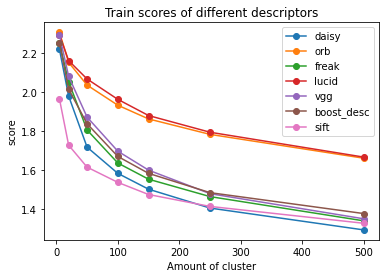

In [12]:
# edit this to your needs!
cluster_amounts_to_test = [5, 20, 50, 100, 150, 250, 500]

# get result from pickle file
result_small_clusters = get_var_from_file("LBM_result_try_different_inputs_small")

# add all data to graph
for result in result_small_clusters:
    descriptor_name = result[0]
    train_scores = result[1]
       
    
    # add data to graph
    x_axis = cluster_amounts_to_test
    y_axis_train = train_scores
    plt.plot(x_axis, y_axis_train,'-', label=descriptor_name, marker='o')
    
    
plt.xlabel('Amount of cluster')
plt.ylabel('score')    
plt.title('Train scores of different descriptors')
plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-train_scores_all_small.png", dpi=300, bbox_inches='tight')    
plt.show()

Here we will make a summary graph of the test scores using the Pickle file.
Note; set the cluster_amounts_to_test to the right value!

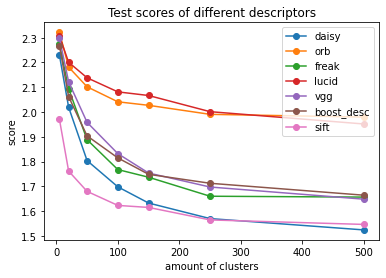

In [13]:
# edit this to your needs!
cluster_amounts_to_test = [5, 20, 50, 100, 150, 250, 500]

# get result from pickle file
result_small_clusters = get_var_from_file("LBM_result_try_different_inputs_small")

# add all data to graph
for result in result_small_clusters:
    descriptor_name = result[0]
    test_scores = result[2]
       
    
    # add data to graph
    x_axis = cluster_amounts_to_test
    y_axis_train = test_scores
    plt.plot(x_axis, y_axis_train,'-', label=descriptor_name, marker='o')
    
    
plt.xlabel('amount of clusters')
plt.ylabel('score')    
plt.title('Test scores of different descriptors')
plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-test_scores_all_small.png", dpi=300, bbox_inches='tight')  
plt.show()

#### 7.a.III: Trying large cluster amounts for all supplied descriptors
Here we prove that overfitting can be done when having to many clusters.

In [ ]:
# Edit to your needs
cluster_amounts_to_test = [500, 1000, 3000, 5000]
descriptors_to_test = ["daisy", "orb", "freak", "lucid", "vgg", "boost_desc", "sift"]
amount_of_averaging_iterations = 5


result = try_different_inputs(cluster_amounts_to_test, descriptors_to_test, amount_of_averaging_iterations)

#-------------------------

#save result in file so that calculations can be done at a later stage
save_var_to_file("LBM_result_try_different_inputs_large", result)


Here we will make a summary graph of the train scores using the Pickle file.
Note; set the cluster_amounts_to_test to the right value!

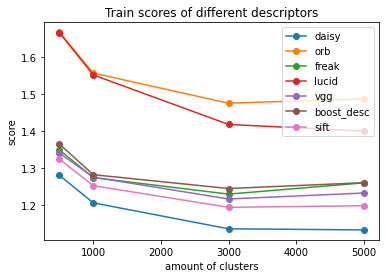

In [14]:
# edit this to your needs!
cluster_amounts_to_test = [500, 1000, 3000, 5000]

# get result from pickle file
result_large_clusters = get_var_from_file("LBM_result_try_different_inputs_large")

# add all data to graph
for result in result_large_clusters:
    descriptor_name = result[0]
    train_scores = result[1]
       
    
    # add data to graph
    x_axis = cluster_amounts_to_test
    y_axis_train = train_scores
    plt.plot(x_axis, y_axis_train,'-', label=descriptor_name, marker='o')
    
    
plt.xlabel('amount of clusters')
plt.ylabel('score')    
plt.title('Train scores of different descriptors')
plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-train_scores_all_large.png", dpi=300, bbox_inches='tight')     
plt.show()

Here we will make a summary graph of the train scores using the Pickle file.
Note; set the cluster_amounts_to_test to the right value!

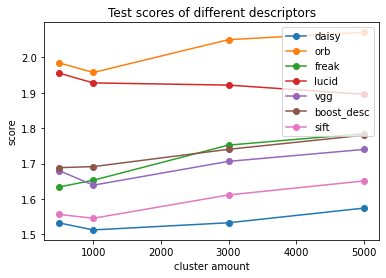

In [21]:
# edit this to your needs!
cluster_amounts_to_test = [500, 1000, 3000, 5000]

# get result from pickle file
result_large_clusters = get_var_from_file("LBM_result_try_different_inputs_large")

# add all data to graph
for result in result_large_clusters:
    descriptor_name = result[0]
    test_scores = result[2]
       
    
    # add data to graph
    x_axis = cluster_amounts_to_test
    y_axis_train = test_scores
    plt.plot(x_axis, y_axis_train,'-', label=descriptor_name, marker='o')
    
    
plt.xlabel('cluster amount')
plt.ylabel('score')    
plt.title('Test scores of different descriptors')
plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-test_scores_all_large.png", dpi=300, bbox_inches='tight')    
plt.show()

### 7.b: Fine-tuning the validation set
Documented in the report, section: Fine-tuning the validation set

#### 7.b.I: Automated functions
These functions will make it easy to test different validation set sizes and get the data required for plotting.
Scoring is done with log_loss which corresponds to the scoring used on the Kaggle compitition.

In [66]:
# edit to current model
from sklearn.linear_model import LogisticRegression


# making the function, ignoring  annoying errors
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
@ignore_warnings(category=ConvergenceWarning)
def try_different_test_fractions(test_fractions_to_test, iterations, use_cv = False):
    #global vars
    train_scores = [0 for x in test_fractions_to_test]
    test_scores = [0 for x in test_fractions_to_test]
    
    
    # ----------------- open pickle files ----------------- 
    with open(filepattern_descriptor_train.format(optima_descriptor), 'rb') as pkl_file_train:
        train_features_from_pkl = pickle.load(pkl_file_train)

    with open(filepattern_descriptor_test.format(optima_descriptor), 'rb') as pkl_file_test:
        test_features_from_pkl = pickle.load(pkl_file_test)

    # ----------------- get the wanted clusters ----------------- 
    clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=optima_clusters)

    # ----------------- encode all train images ----------------- 
    train_data = []
    train_labels = []

    for image_features in train_features_from_pkl:
        bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
        train_data.append(bow_feature_vector)
        train_labels.append(image_features.label)

    # ----------------- make labels numerical ----------------- 
    train_labels_text = train_labels[:]

    label_encoder = sklearn.preprocessing.LabelEncoder()
    label_encoder.fit(label_strings)
    train_labels = label_encoder.transform(train_labels)

    # ----------------- encode all test images ----------------- 
    test_data_by_kaggle = []
    for image_features in test_features_from_pkl:
        bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
        test_data_by_kaggle.append(bow_feature_vector)

    for _ in range(iterations):
        for i in range(len(test_fractions_to_test)):
            # ----------------- setup loop ----------------- 
            test_fraction = test_fractions_to_test[i]

            #edit to current model
            model = LogisticRegression(class_weight=optima_class_weight,
                           C=optima_C, 
                           max_iter=optima_max_iter, 
                           fit_intercept=optima_fit_intercept)

            # ----------------- making subsets ----------------- 
            train_data_split, test_data_split, train_labels_split, test_labels_split = train_test_split(train_data, train_labels, test_size = test_fraction, stratify=train_labels)

            # ----------------- making model ----------------- 
            # step 3: train the model on the training data

            model.fit(train_data_split, train_labels_split)

            # step 4: predict labels for test data 
            predictions_probability_train = model.predict_proba(train_data_split)
            predictions_probability_test = model.predict_proba(test_data_split)

            # step 4: calculate the accuracy of the model on the train set and on the test set
            # We try to use log_loss where possible which corresponds to the scoring used on the Kaggle compitition

            if use_cv:
                folds = StratifiedKFold(n_splits=5, shuffle=True)
                train_score = - cross_val_score(model, train_data_split, train_labels_split, cv=folds, scoring='neg_log_loss')
                test_score = - cross_val_score(model, test_data_split, test_labels_split, cv=folds, scoring='neg_log_loss')
            else:
                train_score = log_loss(train_labels_split, predictions_probability_train)
                test_score = log_loss(test_labels_split, predictions_probability_test)
            
            train_scores[i] += train_score
            test_scores[i] += test_score

            print("Loop ", i, " -> Accuracy of " + optima_descriptor + " driven model with ", optima_clusters, " clusters and ", test_fraction, " test size: ",train_score," (train), ",test_score," (test)")
        
    return [[x/iterations for x in train_scores], [x/iterations for x in test_scores]]

    
#-------------------------



def save_var_to_file(filename, network):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(network, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)
    
#save to file example
#save_var_to_file("testabc", erdos_renye_network)
    
#open from file example
#from_file = get_var_from_file("testabc")




#### 7.b.II: Finding optimal for optimal descriptor

In [ ]:
# Edit to your needs
test_fractions_to_test = [0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3]
iterations = 5

result = try_different_test_fractions(test_fractions_to_test, iterations)

#-------------------------

#save result in file so that calculations can be done at a later stage
save_var_to_file("LBM_result_try_different_test_fractions_sift", result)

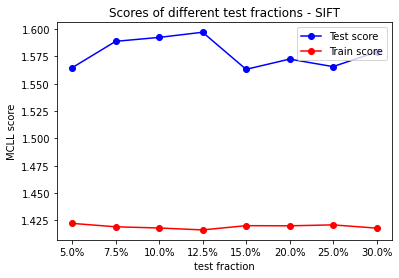

In [110]:
# edit this to your needs!
test_fractions_to_test = [0.05, 0.075, 0.1, 0.125, 0.15, 0.2, 0.25, 0.3]
result_sample_size_sift = get_var_from_file("LBM_result_try_different_test_fractions_sift")

# make values percentage
test_fractions_to_test = [str(x*100)+"%" for x in test_fractions_to_test]

# get result from pickle file
train_scores = result_sample_size_sift[0]
test_scores = result_sample_size_sift[1]

#display graph from results
x_axis = test_fractions_to_test
y_axis_train = train_scores
y_axis_test = test_scores
plt.plot(x_axis, y_axis_test,'b-', label="Test score", marker='o')
plt.plot(x_axis, y_axis_train,'r-', label="Train score", marker='o')

plt.xlabel('test fraction')
plt.ylabel('MCLL score')
plt.title('Scores of different test fractions - SIFT')

plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-test_size_sift.png", dpi=300, bbox_inches='tight')   

plt.show()

### 7.c: Fine-tuning the model parameters
Now that all of the parameters available for the input are fine-tuned, the parameters of the model itself can be optimized.
Documented in the report, section: Fine-tuning the model parameters.
An alternative "faster" function is provided which doesn't do reclustering. This will be faster but less accurate.

#### 7.c.I: Automated functions

In [38]:
# edit to current model
from sklearn.linear_model import LogisticRegression


# making the function
def try_different_model_parameters(iterations, class_weight_parameters, c_parameters, max_iter_parameters, fit_intercept_parameters):
    # find the parameter that is being checked
    
    
    if isinstance(class_weight_parameters, list): 
        list_to_loop = class_weight_parameters
        c_parameters = [c_parameters]*len(list_to_loop)
        max_iter_parameters = [max_iter_parameters]*len(list_to_loop)
        fit_intercept_parameters = [fit_intercept_parameters]*len(list_to_loop)
    elif isinstance(c_parameters, list): 
        list_to_loop = c_parameters
        class_weight_parameters = [class_weight_parameters]*len(list_to_loop)
        max_iter_parameters = [max_iter_parameters]*len(list_to_loop)
        fit_intercept_parameters = [fit_intercept_parameters]*len(list_to_loop)
    elif isinstance(max_iter_parameters, list): 
        list_to_loop = max_iter_parameters
        class_weight_parameters = [class_weight_parameters]*len(list_to_loop)
        c_parameters = [c_parameters]*len(list_to_loop)
        fit_intercept_parameters = [fit_intercept_parameters]*len(list_to_loop)
    elif isinstance(fit_intercept_parameters, list): 
        list_to_loop = fit_intercept_parameters
        class_weight_parameters = [class_weight_parameters]*len(list_to_loop)
        c_parameters = [c_parameters]*len(list_to_loop)
        max_iter_parameters = [max_iter_parameters]*len(list_to_loop)
    else:
        raise Exception("Sorry, provide a list to be tried")
    
    
    #global vars
    train_scores = [0 for x in list_to_loop]
    test_scores = [0 for x in list_to_loop]

    # ----------------- open pickle files ----------------- 
    with open(filepattern_descriptor_train.format(optima_descriptor), 'rb') as pkl_file_train:
        train_features_from_pkl = pickle.load(pkl_file_train)

    with open(filepattern_descriptor_test.format(optima_descriptor), 'rb') as pkl_file_test:
        test_features_from_pkl = pickle.load(pkl_file_test)

    # ----------------- get the wanted clusters ----------------- 
    clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=optima_clusters)

    # ----------------- encode all train images ----------------- 
    train_data = []
    train_labels = []

    for image_features in train_features_from_pkl:
        bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
        train_data.append(bow_feature_vector)
        train_labels.append(image_features.label)

    # ----------------- make labels numerical ----------------- 
    label_encoder = sklearn.preprocessing.LabelEncoder()
    label_encoder.fit(label_strings)
    train_labels = label_encoder.transform(train_labels)

    # ----------------- encode all test images ----------------- 
    test_data_by_kaggle = []
    for image_features in test_features_from_pkl:
        bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
        test_data_by_kaggle.append(bow_feature_vector)

    # ----------------- making subsets ----------------- 
    train_data_split, test_data_split, train_labels_split, test_labels_split = make_test_set_for_loops(train_data, train_labels)
            
            

    
    for _ in range(iterations):
        for i in range(len(list_to_loop)):
            # ----------------- setup loop ----------------- 
            #edit to current model
            model = LogisticRegression(class_weight=class_weight_parameters[i], 
                                       C=c_parameters[i], 
                                       max_iter=max_iter_parameters[i], 
                                       fit_intercept=fit_intercept_parameters[i])
            

            # ----------------- making model ----------------- 
            # step 3: train the model on the training data

            model.fit(train_data_split, train_labels_split)

            # step 4: predict labels for test data 
            predictions_probability_train = model.predict_proba(train_data_split)
            predictions_probability_test = model.predict_proba(test_data_split)

            # step 4: calculate the accuracy of the model on the train set and on the test set
            # We try to use log_loss where possible which corresponds to the scoring used on the Kaggle compitition

            train_score = log_loss(train_labels_split, predictions_probability_train)
            test_score = log_loss(test_labels_split, predictions_probability_test)
            
            train_scores[i] += train_score
            test_scores[i] += test_score

            print("Loop ",
                  i,
                  " -> Accuracy of model with class_weight = ",
                  class_weight_parameters[i], 
                  ", C = ", 
                  c_parameters[i], 
                  " max_iter: ",
                  max_iter_parameters[i],
                  " fit_intercept: ",
                  fit_intercept_parameters[i],
                  ": ",
                  train_score,
                  " (train), "
                  ,test_score,
                  " (test)")
        
    return [[x/iterations for x in train_scores], [x/iterations for x in test_scores]]

    
#-------------------------

def save_var_to_file(filename, network):
    with open('savefiles/' + filename +'.pkl','wb') as f:
        pickle.dump(network, f)

def get_var_from_file(filename):
    with open('savefiles/' + filename +'.pkl','rb') as f:
        return pickle.load(f)
    
#save to file example
#save_var_to_file("testabc", erdos_renye_network)
    
#open from file example
#from_file = get_var_from_file("testabc")




#### 7.c.II: class_weight parameter

In [44]:
iterations = 10
class_weight_parameters = [None, "balanced"]
c_parameters = optima_C
max_iter_parameters = optima_max_iter
fit_intercept_parameters = optima_fit_intercept

result = try_different_model_parameters(iterations, class_weight_parameters, c_parameters, max_iter_parameters, fit_intercept_parameters)


#-------------------------

#save result in file so that calculations can be done at a later stage
save_var_to_file("try_different_model_parameters_class_weight", result)

training took 16.461901664733887 seconds
Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.3889533326724641  (train),  1.5722772596522563  (test)
Loop  1  -> Accuracy of model with class_weight =  balanced , C =  3  max_iter:  250  fit_intercept:  True :  1.4448554770548925  (train),  1.6497492118491277  (test)
Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.3889533326724641  (train),  1.5722772596522563  (test)
Loop  1  -> Accuracy of model with class_weight =  balanced , C =  3  max_iter:  250  fit_intercept:  True :  1.4448554770548925  (train),  1.6497492118491277  (test)
Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.3889533326724641  (train),  1.5722772596522563  (test)
Loop  1  -> Accuracy of model with class_weight =  balanced , C =  3  max_iter:  250  fit_intercept:  True :  1.4448554770548925  (train

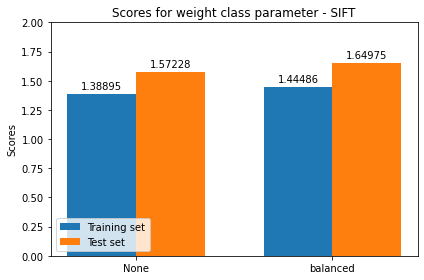

In [45]:
# edit this to your needs!
labels = ["None", "balanced"]

# get result from pickle file
result_sample_size_sift = get_var_from_file("try_different_model_parameters_class_weight")
train_scores = result_sample_size_sift[0]
train_scores = [round(x, 5) for x in train_scores]
test_scores = result_sample_size_sift[1]
test_scores = [round(x, 5) for x in test_scores]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_scores, width, label='Training set')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test set')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for weight class parameter - SIFT')
ax.set_ylim([0,2])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower left")


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()


plt.savefig("../graphs/2/2-LBM-model_weight_class.png", dpi=300, bbox_inches='tight')
plt.show()

#### 7.c.III: fit_intercept parameter

In [46]:
iterations = 10
class_weight_parameters = optima_class_weight
c_parameters = optima_C
max_iter_parameters = optima_max_iter
fit_intercept_parameters = [True, False]

result = try_different_model_parameters(iterations, class_weight_parameters, c_parameters, max_iter_parameters, fit_intercept_parameters)


#-------------------------

#save result in file so that calculations can be done at a later stage
save_var_to_file("try_different_model_parameters_fit_intercept", result)

training took 17.800485372543335 seconds
Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.4195110092198493  (train),  1.5162945808709272  (test)
Loop  1  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  False :  1.4405656904098942  (train),  1.530814301649947  (test)
Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.4195110092198493  (train),  1.5162945808709272  (test)
Loop  1  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  False :  1.4405656904098942  (train),  1.530814301649947  (test)
Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.4195110092198493  (train),  1.5162945808709272  (test)
Loop  1  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  False :  1.4405656904098942  (train),  1.53081

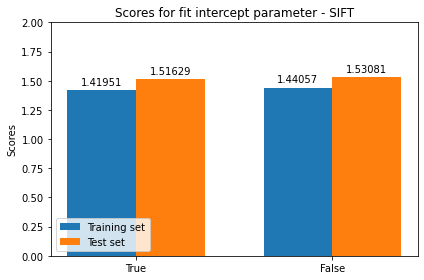

In [47]:
# edit this to your needs!
labels = ["True", "False"]

# get result from pickle file
result = get_var_from_file("try_different_model_parameters_fit_intercept")
train_scores = result[0]
train_scores = [round(x, 5) for x in train_scores]
test_scores = result[1]
test_scores = [round(x, 5) for x in test_scores]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_scores, width, label='Training set')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test set')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for fit intercept parameter - SIFT')
ax.set_ylim([0,2])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="lower left")


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()


plt.savefig("../graphs/2/2-LBM-model_fit_intercept.png", dpi=300, bbox_inches='tight')
plt.show()

#### 7.c.IV: max_iter parameter

In [48]:
iterations = 10
class_weight_parameters = optima_class_weight
c_parameters = optima_C
max_iter_parameters = [50, 100, 150, 200, 250]
fit_intercept_parameters = optima_fit_intercept

result = try_different_model_parameters(iterations, class_weight_parameters, c_parameters, max_iter_parameters, fit_intercept_parameters)


#-------------------------

#save result in file so that calculations can be done at a later stage
save_var_to_file("try_different_model_parameters_max_iter", result)

training took 16.905890703201294 seconds


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  50  fit_intercept:  True :  1.4321466495164556  (train),  1.536083679141538  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  100  fit_intercept:  True :  1.4143705719025768  (train),  1.5337006274370308  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  2  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  150  fit_intercept:  True :  1.414260483593061  (train),  1.5339820981913908  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  200  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  50  fit_intercept:  True :  1.4321466495164556  (train),  1.536083679141538  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  100  fit_intercept:  True :  1.4143705719025768  (train),  1.5337006274370308  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  2  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  150  fit_intercept:  True :  1.414260483593061  (train),  1.5339820981913908  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  200  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  50  fit_intercept:  True :  1.4321466495164556  (train),  1.536083679141538  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  100  fit_intercept:  True :  1.4143705719025768  (train),  1.5337006274370308  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  2  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  150  fit_intercept:  True :  1.414260483593061  (train),  1.5339820981913908  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  200  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)
Loop 

c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


 0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  50  fit_intercept:  True :  1.4321466495164556  (train),  1.536083679141538  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  100  fit_intercept:  True :  1.4143705719025768  (train),  1.5337006274370308  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  2  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  150  fit_intercept:  True :  1.414260483593061  (train),  1.5339820981913908  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  200  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  50  fit_intercept:  True :  1.4321466495164556  (train),  1.536083679141538  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  100  fit_intercept:  True :  1.4143705719025768  (train),  1.5337006274370308  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  2  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  150  fit_intercept:  True :  1.414260483593061  (train),  1.5339820981913908  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  200  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  50  fit_intercept:  True :  1.4321466495164556  (train),  1.536083679141538  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  100  fit_intercept:  True :  1.4143705719025768  (train),  1.5337006274370308  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  2  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  150  fit_intercept:  True :  1.414260483593061  (train),  1.5339820981913908  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  200  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  50  fit_intercept:  True :  1.4321466495164556  (train),  1.536083679141538  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  100  fit_intercept:  True :  1.4143705719025768  (train),  1.5337006274370308  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  2  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  150  fit_intercept:  True :  1.414260483593061  (train),  1.5339820981913908  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  200  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  50  fit_intercept:  True :  1.4321466495164556  (train),  1.536083679141538  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  100  fit_intercept:  True :  1.4143705719025768  (train),  1.5337006274370308  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  2  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  150  fit_intercept:  True :  1.414260483593061  (train),  1.5339820981913908  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  200  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  50  fit_intercept:  True :  1.4321466495164556  (train),  1.536083679141538  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  100  fit_intercept:  True :  1.4143705719025768  (train),  1.5337006274370308  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  2  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  150  fit_intercept:  True :  1.414260483593061  (train),  1.5339820981913908  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  200  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  0  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  50  fit_intercept:  True :  1.4321466495164556  (train),  1.536083679141538  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  1  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  100  fit_intercept:  True :  1.4143705719025768  (train),  1.5337006274370308  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  2  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  150  fit_intercept:  True :  1.414260483593061  (train),  1.5339820981913908  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  200  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  3  max_iter:  250  fit_intercept:  True :  1.4142473204639  (train),  1.5339307811947362  (test)


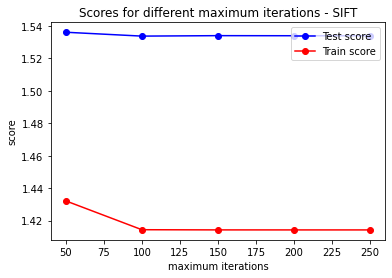

In [49]:
# edit this to your needs!
x_axis = [50, 100, 150, 200, 250]

# get result from pickle file
result = get_var_from_file("try_different_model_parameters_max_iter")
train_scores = result[0]
test_scores = result[1]

#display graph from results
y_axis_train = train_scores
y_axis_test = test_scores
plt.plot(x_axis, y_axis_test,'b-', label="Test score", marker='o')
plt.plot(x_axis, y_axis_train,'r-', label="Train score", marker='o')

plt.xlabel('maximum iterations')
plt.ylabel('score')
plt.title('Scores for different maximum iterations - SIFT')

plt.legend(loc="upper right")
plt.savefig("../graphs/2/2-LBM-model_max_iter.png")

plt.show()

#### 7.c.V: C parameter
For this fine-tuning an automated solution will be provided by using gridsearch.
This will be compared with the manual methods we've been using.
For this step it is assumed the loading in of the data has been done at least once.

results initial experiment:
```
-1.562 (+/-0.057) for {'linearbaselinemodel__C': 5}
-1.568 (+/-0.049) for {'linearbaselinemodel__C': 3}
-1.575 (+/-0.070) for {'linearbaselinemodel__C': 10}
-1.599 (+/-0.040) for {'linearbaselinemodel__C': 1.5}
-1.630 (+/-0.037) for {'linearbaselinemodel__C': 1.0}
-1.686 (+/-0.115) for {'linearbaselinemodel__C': 100}
-1.701 (+/-0.032) for {'linearbaselinemodel__C': 0.5}
-1.747 (+/-0.146) for {'linearbaselinemodel__C': 1000}
-1.756 (+/-0.155) for {'linearbaselinemodel__C': 10000}
-1.939 (+/-0.022) for {'linearbaselinemodel__C': 0.1}
-2.266 (+/-0.006) for {'linearbaselinemodel__C': 0.01}
-2.361 (+/-0.003) for {'linearbaselinemodel__C': 0.001}
-2.373 (+/-0.003) for {'linearbaselinemodel__C': 0.0001}
-2.374 (+/-0.003) for {'linearbaselinemodel__C': 1e-05}
```

results further fine-tuning (top 10):
```
-1.568 (+/-0.050) for {'linearbaselinemodel__C': 5}
-1.569 (+/-0.046) for {'linearbaselinemodel__C': 4}
-1.570 (+/-0.044) for {'linearbaselinemodel__C': 3.5}
-1.573 (+/-0.042) for {'linearbaselinemodel__C': 3}
-1.578 (+/-0.039) for {'linearbaselinemodel__C': 2.5}
-1.587 (+/-0.036) for {'linearbaselinemodel__C': 2}
-1.602 (+/-0.032) for {'linearbaselinemodel__C': 1.5}
-1.632 (+/-0.029) for {'linearbaselinemodel__C': 1.0}
...
```

In [14]:
# edit to the optimals
class_weight = optima_class_weight
max_iter = optima_max_iter
fit_intercept = optima_fit_intercept

linear_baseline_model_pipeline = Pipeline([
    ('linearbaselinemodel',LogisticRegression(C=1.0, class_weight=class_weight, max_iter=max_iter,fit_intercept=fit_intercept))
])

# ----------------- open pickle files ----------------- 
with open(filepattern_descriptor_train.format(optima_descriptor), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)

with open(filepattern_descriptor_test.format(optima_descriptor), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)

# ----------------- get the wanted clusters ----------------- 
clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=optima_clusters)

# ----------------- encode all train images ----------------- 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)

# ----------------- make labels numerical ----------------- 
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

# ----------------- encode all test images ----------------- 
test_data_by_kaggle = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data_by_kaggle.append(bow_feature_vector)

# ----------------- making subsets ----------------- 
train_data_split, test_data_split, train_labels_split, test_labels_split = make_test_set_for_loops(train_data, train_labels)


# Set the parameters by cross-validation
tuned_parameters = [{'linearbaselinemodel__C': [0.00001, 0.0001, 0.001, 0.01 , 0.1, 0.5, 1.0, 1.5, 3, 5, 10, 100, 1000, 10000]}]

folds = StratifiedKFold(n_splits=5, shuffle=True)
CV = GridSearchCV(linear_baseline_model_pipeline, tuned_parameters, cv=folds, scoring='neg_log_loss', n_jobs=-1, verbose=3)
CV.fit(train_data_split, train_labels_split)

print("Best parameter set found on development set: ", CV.best_params_)

print("Grid scores on training data set:\n")
cv_means = CV.cv_results_['mean_test_score']
cv_stds = CV.cv_results_['std_test_score']
for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    

training took 27.180437088012695 seconds
Fitting 5 folds for each of 14 candidates, totalling 70 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed:   11.6s finished


Best parameter set found on development set:  {'linearbaselinemodel__C': 5}
Grid scores on training data set:

-2.374 (+/-0.003) for {'linearbaselinemodel__C': 1e-05}
-2.373 (+/-0.003) for {'linearbaselinemodel__C': 0.0001}
-2.361 (+/-0.003) for {'linearbaselinemodel__C': 0.001}
-2.266 (+/-0.006) for {'linearbaselinemodel__C': 0.01}
-1.939 (+/-0.022) for {'linearbaselinemodel__C': 0.1}
-1.701 (+/-0.032) for {'linearbaselinemodel__C': 0.5}
-1.630 (+/-0.037) for {'linearbaselinemodel__C': 1.0}
-1.599 (+/-0.040) for {'linearbaselinemodel__C': 1.5}
-1.568 (+/-0.049) for {'linearbaselinemodel__C': 3}
-1.562 (+/-0.057) for {'linearbaselinemodel__C': 5}
-1.575 (+/-0.070) for {'linearbaselinemodel__C': 10}
-1.686 (+/-0.115) for {'linearbaselinemodel__C': 100}
-1.747 (+/-0.146) for {'linearbaselinemodel__C': 1000}
-1.756 (+/-0.155) for {'linearbaselinemodel__C': 10000}


In [15]:
# edit to the optimals
class_weight = optima_class_weight
max_iter = optima_max_iter
fit_intercept = optima_fit_intercept

linear_baseline_model_pipeline = Pipeline([
    ('linearbaselinemodel',LogisticRegression(C=1.0, class_weight=class_weight, max_iter=max_iter,fit_intercept=fit_intercept))
])

# ----------------- open pickle files ----------------- 
with open(filepattern_descriptor_train.format(optima_descriptor), 'rb') as pkl_file_train:
    train_features_from_pkl = pickle.load(pkl_file_train)

with open(filepattern_descriptor_test.format(optima_descriptor), 'rb') as pkl_file_test:
    test_features_from_pkl = pickle.load(pkl_file_test)

# ----------------- get the wanted clusters ----------------- 
clustered_codebook = helpers.createCodebook(train_features_from_pkl, codebook_size=optima_clusters)

# ----------------- encode all train images ----------------- 
train_data = []
train_labels = []

for image_features in train_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    train_data.append(bow_feature_vector)
    train_labels.append(image_features.label)

# ----------------- make labels numerical ----------------- 
label_encoder = sklearn.preprocessing.LabelEncoder()
label_encoder.fit(label_strings)
train_labels = label_encoder.transform(train_labels)

# ----------------- encode all test images ----------------- 
test_data_by_kaggle = []
for image_features in test_features_from_pkl:
    bow_feature_vector = helpers.encodeImage(image_features.data, clustered_codebook)
    test_data_by_kaggle.append(bow_feature_vector)

# ----------------- making subsets ----------------- 
train_data_split, test_data_split, train_labels_split, test_labels_split = make_test_set_for_loops(train_data, train_labels)


# Set the parameters by cross-validation
tuned_parameters = [{'linearbaselinemodel__C': [1.0, 1.5, 2, 2.5, 3, 3.5, 4, 5]}]

folds = StratifiedKFold(n_splits=5, shuffle=True)
CV = GridSearchCV(linear_baseline_model_pipeline, tuned_parameters, cv=folds, scoring='neg_log_loss', n_jobs=-1, verbose=3)
CV.fit(train_data_split, train_labels_split)

print("Best parameter set found on development set: ", CV.best_params_)

print("Grid scores on training data set:\n")
cv_means = CV.cv_results_['mean_test_score']
cv_stds = CV.cv_results_['std_test_score']
for mean, std, params in zip(cv_means, cv_stds, CV.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    

training took 23.738117456436157 seconds
Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.7s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    6.7s finished


Best parameter set found on development set:  {'linearbaselinemodel__C': 5}
Grid scores on training data set:

-1.632 (+/-0.029) for {'linearbaselinemodel__C': 1.0}
-1.602 (+/-0.032) for {'linearbaselinemodel__C': 1.5}
-1.587 (+/-0.036) for {'linearbaselinemodel__C': 2}
-1.578 (+/-0.039) for {'linearbaselinemodel__C': 2.5}
-1.573 (+/-0.042) for {'linearbaselinemodel__C': 3}
-1.570 (+/-0.044) for {'linearbaselinemodel__C': 3.5}
-1.569 (+/-0.046) for {'linearbaselinemodel__C': 4}
-1.568 (+/-0.050) for {'linearbaselinemodel__C': 5}


Let's compare this to the manual work we've been doing.
Note we are using the "fast" process since the gridsearch also doesn't recompute the clusters.

In [51]:
iterations = 10
class_weight_parameters = optima_class_weight
c_parameters = [0.00001, 0.0001, 0.001, 0.01 , 0.1, 0.5, 1.0, 1.5, 3, 5, 10, 100, 1000, 10000]
max_iter_parameters = optima_max_iter
fit_intercept_parameters = optima_fit_intercept

result = try_different_model_parameters(iterations, class_weight_parameters, c_parameters, max_iter_parameters, fit_intercept_parameters)


#-------------------------

#save result in file so that calculations can be done at a later stage
save_var_to_file("try_different_model_parameters_c", result)

training took 14.878491163253784 seconds
Loop  0  -> Accuracy of model with class_weight =  None , C =  1e-05  max_iter:  250  fit_intercept:  True :  2.3743181500723107  (train),  2.373532634984008  (test)
Loop  1  -> Accuracy of model with class_weight =  None , C =  0.0001  max_iter:  250  fit_intercept:  True :  2.372761642012839  (train),  2.372062015372578  (test)
Loop  2  -> Accuracy of model with class_weight =  None , C =  0.001  max_iter:  250  fit_intercept:  True :  2.3576459629949515  (train),  2.3577796422819213  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  0.01  max_iter:  250  fit_intercept:  True :  2.2406583294088835  (train),  2.2478290107087853  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  0.1  max_iter:  250  fit_intercept:  True :  1.8772896030318411  (train),  1.916360462119613  (test)
Loop  5  -> Accuracy of model with class_weight =  None , C =  0.5  max_iter:  250  fit_intercept:  True :  1.6060359116853573  (t

c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  10  -> Accuracy of model with class_weight =  None , C =  10  max_iter:  250  fit_intercept:  True :  1.3206882768166435  (train),  1.6033852471928225  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  11  -> Accuracy of model with class_weight =  None , C =  100  max_iter:  250  fit_intercept:  True :  1.282543172618801  (train),  1.6840193485867918  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  12  -> Accuracy of model with class_weight =  None , C =  1000  max_iter:  250  fit_intercept:  True :  1.280253686264483  (train),  1.7088782014222235  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  13  -> Accuracy of model with class_weight =  None , C =  10000  max_iter:  250  fit_intercept:  True :  1.280120632079082  (train),  1.7177836284750156  (test)
Loop  0  -> Accuracy of model with class_weight =  None , C =  1e-05  max_iter:  250  fit_intercept:  True :  2.3743181500723107  (train),  2.373532634984008  (test)
Loop  1  -> Accuracy of model with class_weight =  None , C =  0.0001  max_iter:  250  fit_intercept:  True :  2.372761642012839  (train),  2.372062015372578  (test)
Loop  2  -> Accuracy of model with class_weight =  None , C =  0.001  max_iter:  250  fit_intercept:  True :  2.3576459629949515  (train),  2.3577796422819213  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  0.01  max_iter:  250  fit_intercept:  True :  2.2406583294088835  (train),  2.2478290107087853  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  0.1  max_iter:  250  fit_intercept:  True :  1.8772896030318411  (train),  1.916360462119613  (test)
Loop

c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  10  -> Accuracy of model with class_weight =  None , C =  10  max_iter:  250  fit_intercept:  True :  1.3206882768166435  (train),  1.6033852471928225  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  11  -> Accuracy of model with class_weight =  None , C =  100  max_iter:  250  fit_intercept:  True :  1.282543172618801  (train),  1.6840193485867918  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  12  -> Accuracy of model with class_weight =  None , C =  1000  max_iter:  250  fit_intercept:  True :  1.280253686264483  (train),  1.7088782014222235  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  13  -> Accuracy of model with class_weight =  None , C =  10000  max_iter:  250  fit_intercept:  True :  1.280120632079082  (train),  1.7177836284750156  (test)
Loop  0  -> Accuracy of model with class_weight =  None , C =  1e-05  max_iter:  250  fit_intercept:  True :  2.3743181500723107  (train),  2.373532634984008  (test)
Loop  1  -> Accuracy of model with class_weight =  None , C =  0.0001  max_iter:  250  fit_intercept:  True :  2.372761642012839  (train),  2.372062015372578  (test)
Loop  2  -> Accuracy of model with class_weight =  None , C =  0.001  max_iter:  250  fit_intercept:  True :  2.3576459629949515  (train),  2.3577796422819213  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  0.01  max_iter:  250  fit_intercept:  True :  2.2406583294088835  (train),  2.2478290107087853  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  0.1  max_iter:  250  fit_intercept:  True :  1.8772896030318411  (train),  1.916360462119613  (test)
Loop

c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  10  -> Accuracy of model with class_weight =  None , C =  10  max_iter:  250  fit_intercept:  True :  1.3206882768166435  (train),  1.6033852471928225  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  11  -> Accuracy of model with class_weight =  None , C =  100  max_iter:  250  fit_intercept:  True :  1.282543172618801  (train),  1.6840193485867918  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  12  -> Accuracy of model with class_weight =  None , C =  1000  max_iter:  250  fit_intercept:  True :  1.280253686264483  (train),  1.7088782014222235  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  13  -> Accuracy of model with class_weight =  None , C =  10000  max_iter:  250  fit_intercept:  True :  1.280120632079082  (train),  1.7177836284750156  (test)
Loop  0  -> Accuracy of model with class_weight =  None , C =  1e-05  max_iter:  250  fit_intercept:  True :  2.3743181500723107  (train),  2.373532634984008  (test)
Loop  1  -> Accuracy of model with class_weight =  None , C =  0.0001  max_iter:  250  fit_intercept:  True :  2.372761642012839  (train),  2.372062015372578  (test)
Loop  2  -> Accuracy of model with class_weight =  None , C =  0.001  max_iter:  250  fit_intercept:  True :  2.3576459629949515  (train),  2.3577796422819213  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  0.01  max_iter:  250  fit_intercept:  True :  2.2406583294088835  (train),  2.2478290107087853  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  0.1  max_iter:  250  fit_intercept:  True :  1.8772896030318411  (train),  1.916360462119613  (test)
Loop

c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  10  -> Accuracy of model with class_weight =  None , C =  10  max_iter:  250  fit_intercept:  True :  1.3206882768166435  (train),  1.6033852471928225  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  11  -> Accuracy of model with class_weight =  None , C =  100  max_iter:  250  fit_intercept:  True :  1.282543172618801  (train),  1.6840193485867918  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  12  -> Accuracy of model with class_weight =  None , C =  1000  max_iter:  250  fit_intercept:  True :  1.280253686264483  (train),  1.7088782014222235  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  13  -> Accuracy of model with class_weight =  None , C =  10000  max_iter:  250  fit_intercept:  True :  1.280120632079082  (train),  1.7177836284750156  (test)
Loop  0  -> Accuracy of model with class_weight =  None , C =  1e-05  max_iter:  250  fit_intercept:  True :  2.3743181500723107  (train),  2.373532634984008  (test)
Loop  1  -> Accuracy of model with class_weight =  None , C =  0.0001  max_iter:  250  fit_intercept:  True :  2.372761642012839  (train),  2.372062015372578  (test)
Loop  2  -> Accuracy of model with class_weight =  None , C =  0.001  max_iter:  250  fit_intercept:  True :  2.3576459629949515  (train),  2.3577796422819213  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  0.01  max_iter:  250  fit_intercept:  True :  2.2406583294088835  (train),  2.2478290107087853  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  0.1  max_iter:  250  fit_intercept:  True :  1.8772896030318411  (train),  1.916360462119613  (test)
Loop

c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  10  -> Accuracy of model with class_weight =  None , C =  10  max_iter:  250  fit_intercept:  True :  1.3206882768166435  (train),  1.6033852471928225  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  11  -> Accuracy of model with class_weight =  None , C =  100  max_iter:  250  fit_intercept:  True :  1.282543172618801  (train),  1.6840193485867918  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  12  -> Accuracy of model with class_weight =  None , C =  1000  max_iter:  250  fit_intercept:  True :  1.280253686264483  (train),  1.7088782014222235  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  13  -> Accuracy of model with class_weight =  None , C =  10000  max_iter:  250  fit_intercept:  True :  1.280120632079082  (train),  1.7177836284750156  (test)
Loop  0  -> Accuracy of model with class_weight =  None , C =  1e-05  max_iter:  250  fit_intercept:  True :  2.3743181500723107  (train),  2.373532634984008  (test)
Loop  1  -> Accuracy of model with class_weight =  None , C =  0.0001  max_iter:  250  fit_intercept:  True :  2.372761642012839  (train),  2.372062015372578  (test)
Loop  2  -> Accuracy of model with class_weight =  None , C =  0.001  max_iter:  250  fit_intercept:  True :  2.3576459629949515  (train),  2.3577796422819213  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  0.01  max_iter:  250  fit_intercept:  True :  2.2406583294088835  (train),  2.2478290107087853  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  0.1  max_iter:  250  fit_intercept:  True :  1.8772896030318411  (train),  1.916360462119613  (test)
Loop

c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  10  -> Accuracy of model with class_weight =  None , C =  10  max_iter:  250  fit_intercept:  True :  1.3206882768166435  (train),  1.6033852471928225  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  11  -> Accuracy of model with class_weight =  None , C =  100  max_iter:  250  fit_intercept:  True :  1.282543172618801  (train),  1.6840193485867918  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  12  -> Accuracy of model with class_weight =  None , C =  1000  max_iter:  250  fit_intercept:  True :  1.280253686264483  (train),  1.7088782014222235  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  13  -> Accuracy of model with class_weight =  None , C =  10000  max_iter:  250  fit_intercept:  True :  1.280120632079082  (train),  1.7177836284750156  (test)
Loop  0  -> Accuracy of model with class_weight =  None , C =  1e-05  max_iter:  250  fit_intercept:  True :  2.3743181500723107  (train),  2.373532634984008  (test)
Loop  1  -> Accuracy of model with class_weight =  None , C =  0.0001  max_iter:  250  fit_intercept:  True :  2.372761642012839  (train),  2.372062015372578  (test)
Loop  2  -> Accuracy of model with class_weight =  None , C =  0.001  max_iter:  250  fit_intercept:  True :  2.3576459629949515  (train),  2.3577796422819213  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  0.01  max_iter:  250  fit_intercept:  True :  2.2406583294088835  (train),  2.2478290107087853  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  0.1  max_iter:  250  fit_intercept:  True :  1.8772896030318411  (train),  1.916360462119613  (test)
Loop

c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  10  -> Accuracy of model with class_weight =  None , C =  10  max_iter:  250  fit_intercept:  True :  1.3206882768166435  (train),  1.6033852471928225  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  11  -> Accuracy of model with class_weight =  None , C =  100  max_iter:  250  fit_intercept:  True :  1.282543172618801  (train),  1.6840193485867918  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  12  -> Accuracy of model with class_weight =  None , C =  1000  max_iter:  250  fit_intercept:  True :  1.280253686264483  (train),  1.7088782014222235  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  13  -> Accuracy of model with class_weight =  None , C =  10000  max_iter:  250  fit_intercept:  True :  1.280120632079082  (train),  1.7177836284750156  (test)
Loop  0  -> Accuracy of model with class_weight =  None , C =  1e-05  max_iter:  250  fit_intercept:  True :  2.3743181500723107  (train),  2.373532634984008  (test)
Loop  1  -> Accuracy of model with class_weight =  None , C =  0.0001  max_iter:  250  fit_intercept:  True :  2.372761642012839  (train),  2.372062015372578  (test)
Loop  2  -> Accuracy of model with class_weight =  None , C =  0.001  max_iter:  250  fit_intercept:  True :  2.3576459629949515  (train),  2.3577796422819213  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  0.01  max_iter:  250  fit_intercept:  True :  2.2406583294088835  (train),  2.2478290107087853  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  0.1  max_iter:  250  fit_intercept:  True :  1.8772896030318411  (train),  1.916360462119613  (test)
Loop

c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  10  -> Accuracy of model with class_weight =  None , C =  10  max_iter:  250  fit_intercept:  True :  1.3206882768166435  (train),  1.6033852471928225  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  11  -> Accuracy of model with class_weight =  None , C =  100  max_iter:  250  fit_intercept:  True :  1.282543172618801  (train),  1.6840193485867918  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  12  -> Accuracy of model with class_weight =  None , C =  1000  max_iter:  250  fit_intercept:  True :  1.280253686264483  (train),  1.7088782014222235  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  13  -> Accuracy of model with class_weight =  None , C =  10000  max_iter:  250  fit_intercept:  True :  1.280120632079082  (train),  1.7177836284750156  (test)
Loop  0  -> Accuracy of model with class_weight =  None , C =  1e-05  max_iter:  250  fit_intercept:  True :  2.3743181500723107  (train),  2.373532634984008  (test)
Loop  1  -> Accuracy of model with class_weight =  None , C =  0.0001  max_iter:  250  fit_intercept:  True :  2.372761642012839  (train),  2.372062015372578  (test)
Loop  2  -> Accuracy of model with class_weight =  None , C =  0.001  max_iter:  250  fit_intercept:  True :  2.3576459629949515  (train),  2.3577796422819213  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  0.01  max_iter:  250  fit_intercept:  True :  2.2406583294088835  (train),  2.2478290107087853  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  0.1  max_iter:  250  fit_intercept:  True :  1.8772896030318411  (train),  1.916360462119613  (test)
Loop

c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  10  -> Accuracy of model with class_weight =  None , C =  10  max_iter:  250  fit_intercept:  True :  1.3206882768166435  (train),  1.6033852471928225  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  11  -> Accuracy of model with class_weight =  None , C =  100  max_iter:  250  fit_intercept:  True :  1.282543172618801  (train),  1.6840193485867918  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  12  -> Accuracy of model with class_weight =  None , C =  1000  max_iter:  250  fit_intercept:  True :  1.280253686264483  (train),  1.7088782014222235  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  13  -> Accuracy of model with class_weight =  None , C =  10000  max_iter:  250  fit_intercept:  True :  1.280120632079082  (train),  1.7177836284750156  (test)
Loop  0  -> Accuracy of model with class_weight =  None , C =  1e-05  max_iter:  250  fit_intercept:  True :  2.3743181500723107  (train),  2.373532634984008  (test)
Loop  1  -> Accuracy of model with class_weight =  None , C =  0.0001  max_iter:  250  fit_intercept:  True :  2.372761642012839  (train),  2.372062015372578  (test)
Loop  2  -> Accuracy of model with class_weight =  None , C =  0.001  max_iter:  250  fit_intercept:  True :  2.3576459629949515  (train),  2.3577796422819213  (test)
Loop  3  -> Accuracy of model with class_weight =  None , C =  0.01  max_iter:  250  fit_intercept:  True :  2.2406583294088835  (train),  2.2478290107087853  (test)
Loop  4  -> Accuracy of model with class_weight =  None , C =  0.1  max_iter:  250  fit_intercept:  True :  1.8772896030318411  (train),  1.916360462119613  (test)
Loop

c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  10  -> Accuracy of model with class_weight =  None , C =  10  max_iter:  250  fit_intercept:  True :  1.3206882768166435  (train),  1.6033852471928225  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  11  -> Accuracy of model with class_weight =  None , C =  100  max_iter:  250  fit_intercept:  True :  1.282543172618801  (train),  1.6840193485867918  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  12  -> Accuracy of model with class_weight =  None , C =  1000  max_iter:  250  fit_intercept:  True :  1.280253686264483  (train),  1.7088782014222235  (test)


c:\users\lennert\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Loop  13  -> Accuracy of model with class_weight =  None , C =  10000  max_iter:  250  fit_intercept:  True :  1.280120632079082  (train),  1.7177836284750156  (test)


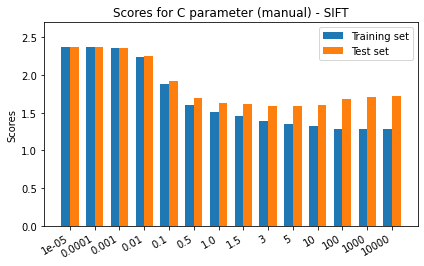

In [52]:
# edit this to your needs!
labels = [0.00001, 0.0001, 0.001, 0.01 , 0.1, 0.5, 1.0, 1.5, 3, 5, 10, 100, 1000, 10000]

# get result from pickle file
result = get_var_from_file("try_different_model_parameters_c")
train_scores = result[0]
train_scores = [round(x, 5) for x in train_scores]
test_scores = result[1]
test_scores = [round(x, 5) for x in test_scores]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_scores, width, label='Training set')
rects2 = ax.bar(x + width/2, test_scores, width, label='Test set')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Scores')
ax.set_title('Scores for C parameter (manual) - SIFT')
ax.set_ylim([0,2.7])
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend(loc="upper right")


fig.tight_layout()

fig.autofmt_xdate()
plt.savefig("../graphs/2/2-LBM-model_manual_c.png")
plt.show()